In [ ]:
!pip install -q segmentation-models-pytorch
!pip install timm
# !pip install --upgrade timm
!pip install ttach
# !pip install torchvision

In [ ]:
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import cv2
import json
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint
from torch.utils.data import Dataset, DataLoader
import ttach as tta
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import torch.backends.cudnn as cudnn
# from accelerate import Accelerator

cudnn.benchmark = True

In [ ]:
import timm
import segmentation_models_pytorch as smp

In [ ]:
print("timm version:", timm.__version__)
print("smp version:", smp.__version__)
print("Encoders:", list(smp.encoders.encoders.keys())[:10])

timm version: 1.0.15
smp version: 0.5.0
Encoders: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x4d', 'resnext101_32x8d', 'resnext101_32x16d', 'resnext101_32x32d']


In [ ]:
print(torch.__version__)
print(torch.version.cuda)

2.6.0+cu124
12.4


----- Load data -----

In [ ]:
# Lấy đường dẫn data
def load_data_paths(base_path):
    train_imgs  = sorted(glob(os.path.join(base_path, "Train", "**", "Image", "*.jpg")))
    train_masks = sorted(glob(os.path.join(base_path, "Train", "**", "Mask", "*.png")))
    test_imgs   = sorted(glob(os.path.join(base_path, "Test", "**", "Image", "*.jpg")))

    return train_imgs, train_masks, test_imgs

In [ ]:
ROOT_PATH = '/kaggle/input/warm-up-program-ai-vietnam-skin-segmentation'

# check root_path
for root, dirs, files in os.walk(ROOT_PATH):
    print(root, len(files))
    break

train_imgs, train_masks, test_imgs = load_data_paths(ROOT_PATH)

print(f'Size train dataset images: {len(train_imgs)}')
print(f'Size train dataset masks: {len(train_masks)}')
print(f'Size test dataset images: {len(test_imgs)}')

/kaggle/input/warm-up-program-ai-vietnam-skin-segmentation 1
Size train dataset images: 2594
Size train dataset masks: 2594
Size test dataset images: 1100


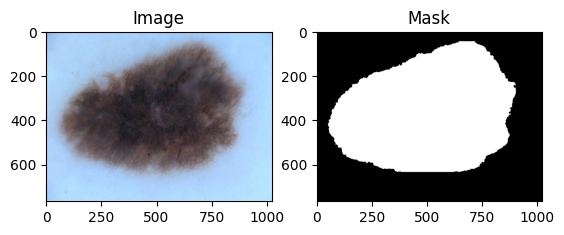

In [ ]:
# vissualize check sample
img = Image.open(train_imgs[0])
mask = Image.open(train_masks[0])

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap="gray")
plt.title("Mask")
plt.show()

----- Preprocessing + Augmentation -----

In [ ]:
# ! rm -rf /kaggle/working/*

In [ ]:
print(os.listdir('/kaggle/working'))

----------------- Hàm xử lý và tăng cường dữ liệu -----------------

In [ ]:
img_size = (512, 512)
mean = [0.485, 0.456, 0.406]      # imagenet_mean
std  = [0.229, 0.224, 0.225]      # imagenet_std

train_transform = A.Compose([
    A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),

    # 🔹 Biến đổi hình học (an toàn)
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5, border_mode=cv2.BORDER_REFLECT_101),

    # 🔹 Biến đổi quang học & màu sắc
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.5),
    A.CLAHE(p=0.3),   # cải thiện contrast vùng lesion
    A.RandomGamma(p=0.3),

    # 🔹 Nhiễu nhẹ
    A.OneOf([
        A.GaussNoise(p=1),
        A.ISONoise(p=1),
    ], p=0.2),

    # 🔹 Blur nhẹ (không quá mạnh để giữ boundary lesion)
    A.GaussianBlur(blur_limit=(3, 3), p=0.2),

    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=512, width=512, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

----- Create dataset & dataloader -----

In [ ]:
# ----- SegmentationDataset -----
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Đọc ảnh trực tiếp ở dạng màu (3 kênh)
        image = cv2.imread(self.image_paths[idx], cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Albumentations expects RGB
        mask = None

        if self.mask_paths is not None:
            mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            # Chia mask cho 255 để chuẩn hóa về khoảng [0, 1]
            mask = mask.astype(np.float32) / 255.0

        if self.transform is not None:
            if mask is not None:
                augmented = self.transform(image=image, mask=mask)
                image = augmented["image"]
                # đảm bảo mask là float
                mask = augmented["mask"].float()
            else:
                augmented = self.transform(image=image)
                image = augmented["image"]

        return (image, mask) if mask is not None else image

In [ ]:
# # ----- Create dataset & dataloader -----
train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
# val_dataset   = SegmentationDataset(val_imgs, val_masks, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
# val_loader   = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)

----- Train model -----

In [ ]:
class TverskyDiceLoss(nn.Module):
    def __init__(self, mix_weight=0.5, tversky_alpha=0.5, tversky_beta=0.5):
        super().__init__()
        self.mix_weight = mix_weight
        self.dice = smp.losses.DiceLoss(mode="binary", eps=1e-5)
        self.tversky = smp.losses.TverskyLoss(
            mode="binary",
            alpha=tversky_alpha,
            beta=tversky_beta,
            eps=1e-5
        )

    def forward(self, preds, masks):
        dice_loss = self.dice(preds, masks)
        tversky_loss = self.tversky(preds, masks)
        return self.mix_weight * dice_loss + (1 - self.mix_weight) * tversky_loss

In [ ]:
class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = smp.losses.DiceLoss(mode="binary")
        self.bce_weight = bce_weight

    def forward(self, preds, masks):
        bce_loss = self.bce(preds, masks)
        dice_loss = self.dice(preds, masks)
        return self.bce_weight * bce_loss + (1 - self.bce_weight) * dice_loss


In [ ]:
# ----- Train function -----
def train_model(model, train_loader, device, epochs=50, lr=1e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    scaler = GradScaler()
    start_epoch = 0

    checkpoint_path = "checkpoint.pth"

    if os.path.exists(checkpoint_path):
        print(f"Tải checkpoint từ {checkpoint_path}...")
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # Tạo một OrderedDict mới và xử lý tiền tố 'module.' một cách an toàn
        from collections import OrderedDict
        new_state_dict = OrderedDict()
        for k, v in checkpoint['model_state_dict'].items():
            name = k[7:] if k.startswith('module.') else k  # Kiểm tra và loại bỏ tiền tố
            new_state_dict[name] = v

        # Tải state_dict đã sửa vào mô hình
        # Lưu ý: Nếu mô hình ban đầu không phải là DataParallel, nó sẽ tự động thêm tiền tố 'module.'
        # khi tải một state_dict không có tiền tố này.
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(new_state_dict)
        else:
            model.load_state_dict(new_state_dict)

        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Đã tải checkpoint thành công. Tiếp tục huấn luyện từ epoch {start_epoch + 1}.")

    for epoch in range(start_epoch + 1, epochs+1):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()

            # print(masks.min(), masks.max())
            masks = masks.unsqueeze(1)

            with autocast(device_type=device):
                preds = model(images)
                loss = criterion(preds, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")
        print(f"Epoch [{epoch}/{epochs}] Loss: {train_loss:.5f}")

        # Lưu checkpoint sau mỗi epoch
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, checkpoint_path)
        torch.save(model.state_dict(), "best_model.pth")

    if os.path.exists("best_model.pth"):
        if isinstance(model, nn.DataParallel):
            model.load_state_dict(torch.load("best_model.pth"))
        else:
            model.load_state_dict(torch.load("best_model.pth"))
    return model

In [ ]:
# model = smp.UnetPlusPlus(
#     encoder_name="timm-efficientnet-b7",
#     encoder_weights="noisy-student",
#     in_channels=3,
#     classes=1,
#     encoder_depth=5,
#     decoder_channels=(256, 128, 64, 32, 16),
#     decoder_attention_type=None,
#     activation=None,
# )
# model.encoder.set_grad_checkpointing(True)

In [ ]:
# ----- Model Execution -----
device = "cuda" if torch.cuda.is_available() else "cpu"

model = smp.UnetPlusPlus(
            encoder_name="timm-efficientnet-b0",
            encoder_weights="noisy-student",
            in_channels=3,
            classes=1,
            # decoder_attention_type="scse",
        ).to(device)
# model.encoder.set_grad_checkpointing(True)

if torch.cuda.device_count() > 1:
    print(f"Sử dụng {torch.cuda.device_count()} GPU!")
    model = nn.DataParallel(model)


model = train_model(
    model, train_loader, device, epochs=25, lr=1e-4
)

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Sử dụng 2 GPU!
Tải checkpoint từ checkpoint.pth...
Đã tải checkpoint thành công. Tiếp tục huấn luyện từ epoch 2.
Current learning rate: 0.0001
Epoch [2/25] Loss: 0.22901
Current learning rate: 0.0001
Epoch [3/25] Loss: 0.18668
Current learning rate: 0.0001
Epoch [4/25] Loss: 0.16844
Current learning rate: 0.0001
Epoch [5/25] Loss: 0.14874
Current learning rate: 0.0001
Epoch [6/25] Loss: 0.13438
Current learning rate: 0.0001
Epoch [7/25] Loss: 0.12857
Current learning rate: 0.0001
Epoch [8/25] Loss: 0.11839
Current learning rate: 0.0001
Epoch [9/25] Loss: 0.10979
Current learning rate: 0.0001
Epoch [10/25] Loss: 0.10691
Current learning rate: 0.0001
Epoch [11/25] Loss: 0.10378
Current learning rate: 0.0001
Epoch [12/25] Loss: 0.10417
Current learning rate: 0.0001
Epoch [13/25] Loss: 0.09947
Current learning rate: 0.0001
Epoch [14/25] Loss: 0.09634
Current learning rate: 0.0001
Epoch [15/25] Loss: 0.09561
Current learning rate: 0.0001
Epoch [16/25] Loss: 0.10572
Current learning rate: 0.

In [ ]:
# !rm -rf /kaggle/working/*

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import os
import cv2
import glob
import matplotlib.pyplot as plt

def plot_img_mask(submission_folder):
    # Kiểm tra xem thư mục có tồn tại và có chứa file nào không
    if not os.path.exists(submission_folder) or not glob.glob(os.path.join(submission_folder, "*.png")):
        print("Thư mục 'submission' không tồn tại hoặc không chứa file mask nào.")
    else:
        # Lấy đường dẫn của file mask
        first_mask_path = sorted(glob.glob(os.path.join(submission_folder, "*.png")))[6]
        img_path = test_imgs[6]

        # Đọc mask bằng OpenCV
        # OpenCV đọc ảnh theo định dạng BGR, nhưng mask chỉ có một kênh màu xám
        img = Image.open(first_mask_path)
        mask = Image.open(img_path).resize((512,512))

        # Hiển thị mask
        # plt.figure(figsize=(6, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Visualizing Mask: {os.path.basename(first_mask_path)}")
        # plt.axis('off')
        plt.show()

        plt.subplot(1, 2, 2)
        plt.imshow(img)
        plt.title(f"Visualizing Mask: {os.path.basename(img_path)}")
        # plt.axis('off')
        plt.show()
    print("Đã hoàn thành việc hiển thị mask.")

In [ ]:
# ----------------- Hàm mã hóa RLE và tạo file nộp bài -----------------
def rle_encode(mask):
    '''
    mask: numpy array, 1 - mask, 0 - background
    returns: run-length encoded string
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
def post_process_mask(mask, min_area=50):
    """
    mask: numpy array (H,W), nhị phân (0/1)
    """
    mask = mask.astype(np.uint8)
    num_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    new_mask = np.zeros_like(mask)
    for i in range(1, num_components):  # bỏ background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            new_mask[labels == i] = 1
    return new_mask

In [ ]:
def predict(model, device, output_dir, output_csv, thresholds=[0.35, 0.45, 0.5]):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    submission_list = []

    for img_path in tqdm(test_imgs, desc="Đang mã hóa RLE"):
        # Đọc ảnh gốc (RGB)
        img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

        # Chuẩn hóa & sang tensor
        img_tensor = val_transform(image=img_raw)["image"].unsqueeze(0).to(device)

        with torch.no_grad():
            pred = model(img_tensor)[0][0].cpu().numpy()

        if len(thresholds) == 1:
            bin_mask = (pred > thresholds[0]).astype(np.uint8)
            final_mask = cv2.resize(bin_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
        else:
            bin_masks = [(pred > th).astype(np.uint8) for th in thresholds]
            final_mask = np.stack(bin_masks, axis=0).sum(axis=0)
            final_mask = (final_mask >= (len(thresholds) // 2 + 1)).astype(np.uint8)

        # final_mask = post_process_mask(final_mask, min_area=50)

        # Lưu mask
        out_path = os.path.join(output_dir, os.path.basename(img_path).replace(".jpg", ".png"))
        cv2.imwrite(out_path, final_mask * 255)

        # encode mask
        rle = rle_encode(final_mask)
        image_id = os.path.basename(img_path).replace(".jpg", "_segmentation")
        submission_list.append([image_id, rle])

    submission_df = pd.DataFrame(submission_list, columns=['ID', 'Predicted_Mask'])
    submission_df.to_csv(output_csv, index=False)

In [ ]:
output_dir = "predictions_06"
output_csv = "submission_06.csv"
predict(model, device, output_dir, output_csv, thresholds=[0.6])

Đang mã hóa RLE: 100%|██████████| 1100/1100 [03:24<00:00,  5.37it/s]


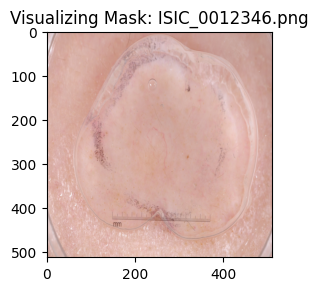

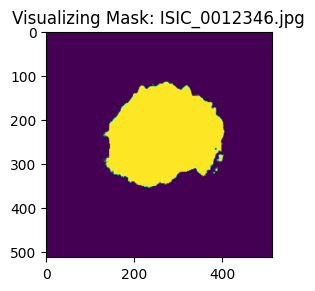

Đã hoàn thành việc hiển thị mask.


In [ ]:
submission_folder = "predictions_06"
plot_img_mask(submission_folder)

In [ ]:
def post_process_mask(mask, min_area=50):
    """
    mask: numpy array (H,W), nhị phân (0/1)
    """
    mask = mask.astype(np.uint8)
    num_components, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)

    new_mask = np.zeros_like(mask)
    for i in range(1, num_components):  # bỏ background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            new_mask[labels == i] = 1
    return new_mask

In [ ]:
def predict_with_tta(model, device, transform,
                     output_dir="predictions",
                     output_csv="submission.csv",
                     thresholds=(0.35, 0.45, 0.5),
                     min_area=50):

    os.makedirs(output_dir, exist_ok=True)
    submission_list = []

    # Khai báo các phép TTA
    tta_transforms = [
        (lambda x: x, lambda x: x),  # gốc
        (lambda x: np.flip(x, axis=1), lambda x: np.flip(x, axis=1)),  # flip H
        (lambda x: np.flip(x, axis=0), lambda x: np.flip(x, axis=0)),  # flip V
        (lambda x: np.flip(np.flip(x, axis=0), axis=1), lambda x: np.flip(np.flip(x, axis=0), axis=1)),  # flip HV
    ]

    model.eval()

    with torch.no_grad():
        for img_path in tqdm(test_imgs, desc="Dự đoán"):
            # Đọc ảnh RGB
            img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

            tta_preds = []

            for aug, deaug in tta_transforms:
                # Augment input
                aug_img = aug(img_raw)

                # Tiền xử lý -> tensor
                img_tensor = transform(image=aug_img)["image"].unsqueeze(0).to(device)

                # Forward qua model
                pred = model(img_tensor)
                pred = torch.sigmoid(pred).squeeze().cpu().numpy()  # (H,W)

                # Deaugment về hệ gốc
                pred = deaug(pred)
                tta_preds.append(pred)

            # Trung bình kết quả TTA
            # final_prob = np.mean(tta_preds, axis=0)
            final_prob = np.max(tta_preds, axis=0)

            if len(thresholds) == 1:
                bin_mask = (final_prob > thresholds[0]).astype(np.uint8)
                final_mask = cv2.resize(bin_mask, (512, 512), interpolation=cv2.INTER_NEAREST)
            else:
                bin_masks = [(final_prob > th).astype(np.uint8) for th in thresholds]
                final_mask = np.stack(bin_masks, axis=0).sum(axis=0)
                final_mask = (final_mask >= (len(thresholds) // 2 + 1)).astype(np.uint8)

            # Hậu xử lý: loại vùng nhỏ hơn min_area
            if min_area > 0:
                final_mask = post_process_mask(final_mask, min_area=min_area)

            # Lưu mask
            out_path = os.path.join(output_dir, os.path.basename(img_path).replace(".jpg", ".png"))
            cv2.imwrite(out_path, final_mask * 255)

            # encode mask
            rle = rle_encode(final_mask)
            image_id = os.path.basename(img_path).replace(".jpg", "_segmentation")
            submission_list.append([image_id, rle])

        submission_df = pd.DataFrame(submission_list, columns=['ID', 'Predicted_Mask'])
        submission_df.to_csv(output_csv, index=False)

In [ ]:
# output_dir = "predictions_tta_ma"
# output_csv = "submission_tta_ma.csv"
# predict_with_tta(model, device, val_transform,
#                      output_dir,
#                      output_csv,
#                      thresholds=[0.5],
#                      min_area=50)

In [ ]:
# def predict_with_tta(models, test_paths, device, transform,
#                      output_dir="predictions", thresholds=[0.35, 0.45, 0.5], min_area=50):
#     """
#     Ensemble + TTA + Multi-threshold voting cho toàn bộ test set
#     """
#     print("🔮 Bắt đầu dự đoán test set với Ensemble + TTA + Multi-threshold voting...")
#     os.makedirs(output_dir, exist_ok=True)

#     # Các phép TTA: (augment_fn, invert_fn)
#     tta_transforms = [
#         (lambda x: x, lambda x: x),  # gốc
#         (lambda x: np.flip(x, axis=1), lambda x: np.flip(x, axis=1)),  # flip H
#         (lambda x: np.flip(x, axis=0), lambda x: np.flip(x, axis=0)),  # flip V
#         (lambda x: np.flip(np.flip(x, axis=0), axis=1), lambda x: np.flip(np.flip(x, axis=0), axis=1)),  # flip HV
#     ]

#     with torch.no_grad():
#         for img_path in tqdm(test_paths, desc="Dự đoán"):
#             # Đọc ảnh gốc (RGB)
#             img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
#             img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

#             tta_preds = []

#             for aug, deaug in tta_transforms:
#                 # Apply TTA (augment ảnh numpy trước khi transform)
#                 img_aug = aug(img_raw)

#                 # Chuẩn hóa & sang tensor
#                 img_tensor = transform(image=img_aug)["image"].unsqueeze(0).to(device)

#                 # Ensemble predict
#                 pred = ensemble_predict(models, img_tensor, device)  # (H,W)

#                 # Inverse TTA
#                 pred = deaug(pred)
#                 tta_preds.append(pred)

#             # Trung bình kết quả TTA
#             final_prob = np.mean(tta_preds, axis=0)

#             # Multi-threshold voting
#             bin_masks = [(final_prob > th).astype(np.uint8) for th in thresholds]
#             voted_mask = np.stack(bin_masks, axis=0).sum(axis=0)
#             voted_mask = (voted_mask >= (len(thresholds) // 2 + 1)).astype(np.uint8)

#             # Hậu xử lý: bỏ vùng nhỏ hơn min_area
#             final_mask = post_process_mask(voted_mask, min_area=min_area)

#             # Resize về 512x512 trước khi lưu
#             # final_mask = cv2.resize(final_mask, (512, 512), interpolation=cv2.INTER_NEAREST)

#             # Lưu mask
#             out_path = os.path.join(output_dir, os.path.basename(img_path).replace(".jpg", ".png"))
#             cv2.imwrite(out_path, final_mask * 255)

#     print(f"✅ Đã lưu toàn bộ kết quả vào: {output_dir}")

In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# model.eval()

# output_dir = "predictions"
# os.makedirs(output_dir, exist_ok=True)
# submission_list = []

# for img_path in tqdm(test_imgs, desc="Đang mã hóa RLE"):
#     # Đọc ảnh gốc (RGB)
#     img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
#     img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

#     # Chuẩn hóa & sang tensor
#     img_tensor = val_transform(image=img_raw)["image"].unsqueeze(0).to(device)

#     with torch.no_grad():
#         pred = model(img_tensor)[0][0].cpu().numpy()

#     mask = (pred > 0.5).astype(np.uint8)
#     mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

#     # Lưu mask
#     out_path = os.path.join(output_dir, os.path.basename(img_path).replace(".jpg", ".png"))
#     cv2.imwrite(out_path, mask * 255)

#     # encode mask
#     rle = rle_encode(mask)
#     image_id = os.path.basename(img_path).replace(".jpg", "_segmentation")
#     submission_list.append([image_id, rle])

# submission_df = pd.DataFrame(submission_list, columns=['ID', 'Predicted_Mask'])
# submission_df.to_csv("submission.csv", index=False)



In [ ]:
# def predict(output_dir, output_csv, threshold=0.5):
#     os.makedirs(output_dir, exist_ok=True)
#     submission_list = []

#     for img_path in tqdm(test_imgs, desc="Đang mã hóa RLE"):
#         # Đọc ảnh gốc (RGB)
#         img_raw = cv2.imread(img_path, cv2.IMREAD_COLOR)
#         img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

#         # Chuẩn hóa & sang tensor
#         img_tensor = val_transform(image=img_raw)["image"].unsqueeze(0).to(device)

#         with torch.no_grad():
#             pred = model(img_tensor)[0][0].cpu().numpy()

#         mask = (pred > threshold).astype(np.uint8)
#         mask = cv2.resize(mask, (512, 512), interpolation=cv2.INTER_NEAREST)

#         # Lưu mask
#         out_path = os.path.join(output_dir, os.path.basename(img_path).replace(".jpg", ".png"))
#         cv2.imwrite(out_path, mask * 255)

#         # encode mask
#         rle = rle_encode(mask)
#         image_id = os.path.basename(img_path).replace(".jpg", "_segmentation")
#         submission_list.append([image_id, rle])

#     submission_df = pd.DataFrame(submission_list, columns=['ID', 'Predicted_Mask'])
#     submission_df.to_csv(output_csv, index=False)